## 1. Libraries and Initial Configuration



In [8]:
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [9]:
from utils import strip_tags_and_emails

In [10]:
def string_to_list(string):
    """
    Splits a string into a list of words.
    Args:
        string (str): The input string.
    Returns:
        list: A list of words.
    """
    words_list = string.split()
    return words_list


# 2. Data cleaning

## 2.1 Load Data

In [12]:
df = pd.read_excel('datos_sinco.xlsx')
df = df.dropna().reset_index(drop=True)
df['messages'] = df['messages'].astype(str).apply(strip_tags_and_emails)
print(f"Dataframe shape after cleaning: {df.shape}")

Dataframe shape after cleaning: (33091, 3)


## 2.2 Token Length Analysis
We analyze the length of the messages in terms of tokens, both with a simple split and using the BERT tokenizer.
This analysis is crucial for selecting the appropriate input sequence length for the BERT model.
**Why is this important?**
-   The input sequence length determines the maximum number of tokens that can be fed into the BERT model for each message.
-   A large input sequence length can make the model slower and unnecessarily pad short messages, wasting computational resources.
-   A small input sequence length can truncate long messages, leading to loss of valuable information.

**Why use BERT tokenizer tokens instead of word count?**
-   The number of tokens generated by the BERT tokenizer is a more accurate reflection of the actual input size for the model.
-   The BERT tokenizer may split words into subwords, especially for words it doesn't recognize, resulting in a different token count compared to a simple word split.
-   Using the BERT tokenizer's token count ensures that we are setting the input sequence length based on the model's actual input representation.


In [14]:
model_name_bert = 'dccuchile/bert-base-spanish-wwm-uncased'
tokenizer_bert = AutoTokenizer.from_pretrained(model_name_bert)
sample_txt = 'esto ES un ejemplo.'
tokens = tokenizer_bert.tokenize(sample_txt)
tokens

['esto', 'es', 'un', 'ejemplo', '.']

Tokenizing the messages using the BERT tokenizer and counting the number of tokens.

In [15]:
df['token_bert'] = df['messages'].apply(tokenizer_bert.tokenize)
df['n_words_bert'] = df['token_bert'].apply(len)
df['tokens_real'] = df['messages'].apply(string_to_list)
df['n_word_real'] = df['tokens_real'].apply(len)


Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors


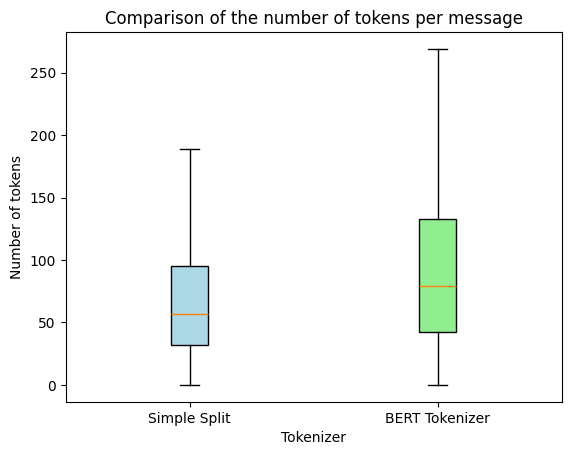

In [17]:
boxplot = plt.boxplot([df['n_word_real'], 
                       df['n_words_bert']],
                       showfliers=False,patch_artist=True)
boxplot['boxes'][0].set(facecolor='lightblue') 
boxplot['boxes'][1].set(facecolor='lightgreen') 
plt.xlabel('Tokenizer')
plt.ylabel('Number of tokens')
plt.title('Comparison of the number of tokens per message')
plt.xticks([1, 2], ['Simple Split','BERT Tokenizer'])
plt.show()

In [18]:
q3_bert = np.percentile(df['n_words_bert'], 75)
q3_real = np.percentile(df['n_word_real'], 75)
print(f"75th percentile (BERT tokenizer): {q3_bert}")
print(f"75th percentile (simple split): {q3_real}")

75th percentile (BERT tokenizer): 133.0
75th percentile (simple split): 95.0


Therefore, the length hyperparameter (number of input tokens) that will be used later will be 133  

## 2.3 Category Analysis

In [19]:
# Determinar cuántas categorías diferentes hay
print("Number of different categories:", df['category'].nunique())

Number of different categories: 162


In [12]:
agrupado_por_frecuencia = df.groupby('category').size().reset_index(name='frecuencia').sort_values(by='frecuencia',ascending=False)
agrupado_por_frecuencia.iloc[0:6].reset_index(drop=True)

,category,frecuencia
0,SOLICITUD DE ACTIVACION USUARIO SINCO,6828
1,CAMBIO DE VOCERIA RESPONSABLE DEL PROYECTO,1889
2,PROCESO DE VALORACION DEL PROYECTO,1849
3,COMO CANCELAR UN PROYECTO REGISTRADO (EN EVALU...,1578
4,PASOS PARA REGISTRAR UN PROYECTO,1360
5,Organizaciones / PROBLEMAS CON EL RIF O CÓDIGO...,1115


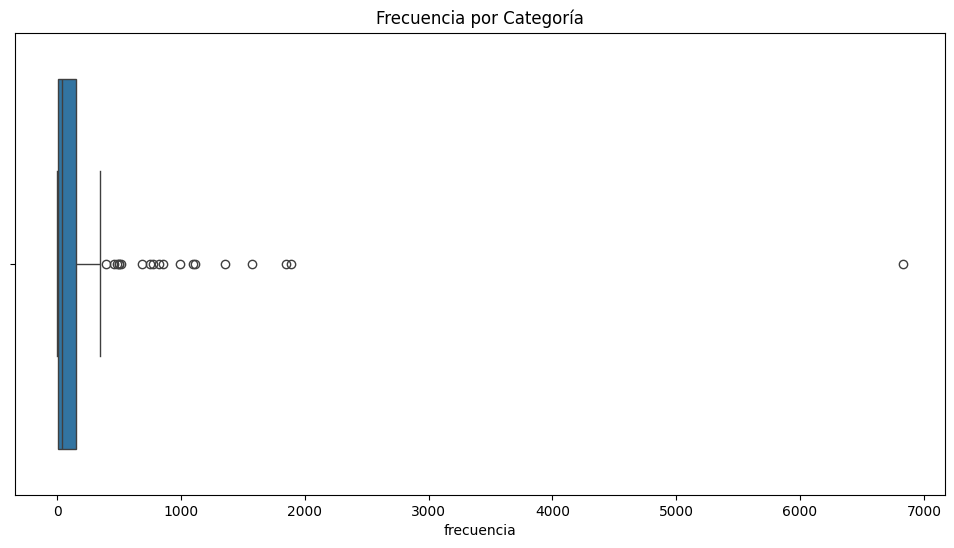

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='frecuencia', data=agrupado_por_frecuencia)
plt.title('Frecuencia por Categoría')
plt.show()

> La frecuencia de las categorías están fiertemente sesgados a la derecha, con muchos valores atípicos




## Uniendo clases
Vemos que 160 son muchas categorías. Es importante reconocer que la data pertenece a dos versiones diferentes de SINCO por lo que fue etiquetada en momentos diferentes, lo que hace que algunos mensajes que deberían estar en una misma categoría esten en dos diferentes con nombres similares por lo que se procederá a agrupar estas categorías que tienen  nombre diferentes pero representan la misma clase.

Empezaremos a unir categorías iguales que tiene nombres diferentes

In [ ]:
# Definimos un diccionario de mapeo


# Reemplazamos las categorías usando el diccionario
df['category'] = df['category'].replace(category_mapping)

# Filtramos las categorías no deseadas
df = df[~df['category'].isin(['Solicitud de activación usuario sinco', '', 'Otros'])]

In [ ]:
print("Número de categorías diferentes:", df['category'].nunique())

Número de categorías diferentes: 114


In [ ]:
agrupado_por_frecuencia = df.groupby('category').size().reset_index(name='frecuencia').sort_values(by='frecuencia',ascending=False)
agrupado_por_frecuencia.iloc[:100]

,category,frecuencia
18,Cambio de vocería,2870
89,Proceso de valoración del proyecto,2843
19,Cancelación de proyecto,2329
94,Rendición de cuentas,1808
85,Pasos para registrar un proyecto,1406
...,...,...
48,ESTATUS DE PROYECTOS FINANCIADOS ENTRE 2011 Y ...,4
113,Voceros y usuarios / REGISTRO DE USUARIO,4
37,DIFICULTAD PARA IMPRIMIR EL COMPROBANTE DE CITA,4
111,Voceros y usuarios / DIFICULTAD EN EL ACCESO A...,4


Usaremos la ley de pareto, escogeremos el 20% de las clases (22 clases) que contienen el 80% de los mensajes. Además se eliminarán las categorías "Solicitud de activación usuario sinco", "otros" y ""

In [ ]:
df

,code,category,messages
1,SINCO/E/2017-0000002248,EJECUCIÓN DEL PROYECTO,me dirijo ante ustedes ya que no tengo conocim...
3,SINCO/E/2017-0000002246,Acompañamiento técnico,"Saludos revolucionarios, camaradas, ya estamos..."
6,SINCO/E/2017-0000002243,DIFICULTAD PARA ACTIVAR EL USUARIO,buen día camaradas trato de enviar los correos...
7,SINCO/E/2017-0000002242,Rendición de cuentas,"Reciban un saludo bolivariano, chavista y anti..."
10,SINCO/E/2017-0000002239,CAMBIO DE PROYECTOS EN EJECUCION- PROCEDIMIENTO,buen día.. el proyecto de nuestro consejo comu...
...,...,...,...
32555,COM-24041800007149,Problemas con el RIF o código Situr,ANTE TODO RECIBAN UN CORDIAL SALUDO POR MEDIO...
32556,COM-24041800007148,Problemas con el RIF o código Situr,Buenas noches un saludo revoluciónario camarad...
32557,COM-24041800007147,Problemas con el RIF o código Situr,Bueno días camarada le escribo para q presten ...
32559,COM-24041800007145,Problemas con el RIF o código Situr,Buenos días. Les envié el rif de la asociación...


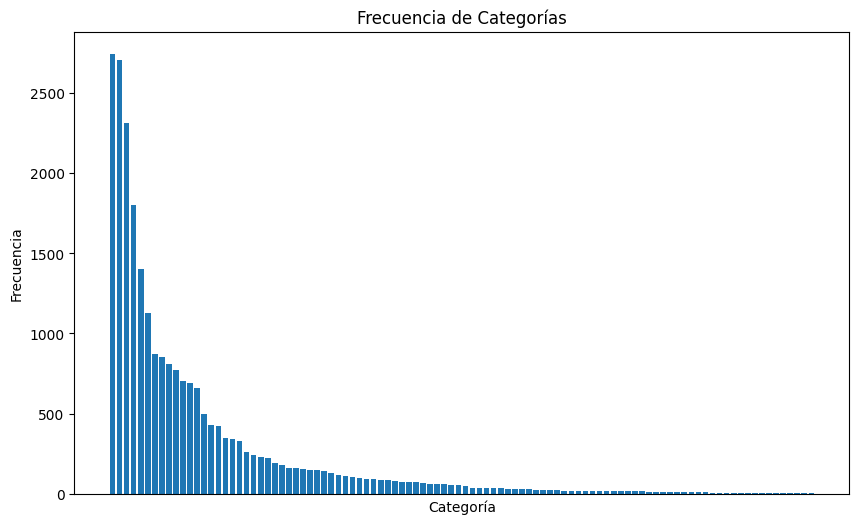

In [ ]:
agrupado_por_frecuencia = agrupado_por_frecuencia.iloc[:100]
# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(agrupado_por_frecuencia['category'], agrupado_por_frecuencia['frecuencia'])
plt.title('Frecuencia de Categorías')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.xticks([])  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()

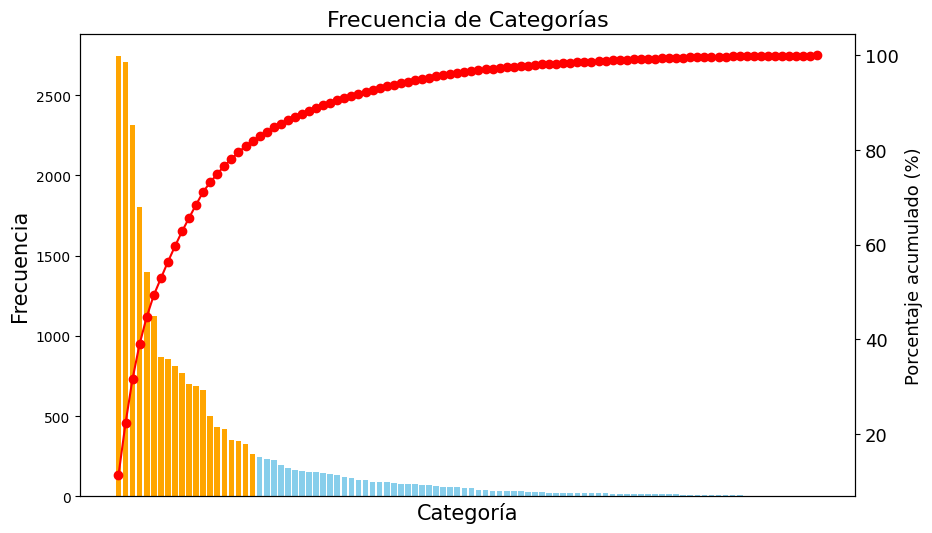

In [ ]:
# Calcula los valores acumulados y el porcentaje acumulado
agrupado_por_frecuencia['frecuencia_acum'] = agrupado_por_frecuencia['frecuencia'].cumsum()
agrupado_por_frecuencia['porcentaje_acum'] = agrupado_por_frecuencia['frecuencia_acum'] / agrupado_por_frecuencia['frecuencia'].sum() * 100

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(agrupado_por_frecuencia['category'], agrupado_por_frecuencia['frecuencia'], color='skyblue')  # Todas las barras en color azul claro
plt.bar(agrupado_por_frecuencia['category'][:20], agrupado_por_frecuencia['frecuencia'][:20], color='orange')  # Las primeras 20 barras en color naranja
plt.title('Frecuencia de Categorías y Distribución de Pareto',fontsize=16)
plt.title('Frecuencia de Categorías',fontsize=16)
plt.xlabel('Categoría',fontsize=15)
plt.ylabel('Frecuencia',fontsize=15)

# Agrega la distribución de Pareto
plt.twinx()
plt.plot(agrupado_por_frecuencia['category'], agrupado_por_frecuencia['porcentaje_acum'], color='r', marker='o')
plt.ylabel('Porcentaje acumulado (%)', fontsize=13)
plt.xticks([])  # Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(fontsize=13)  # Tamaño de la fuente del eje x
plt.yticks(fontsize=13)  # Tamaño de la fuente del eje y
plt.show()



## Palabras más frecuentes

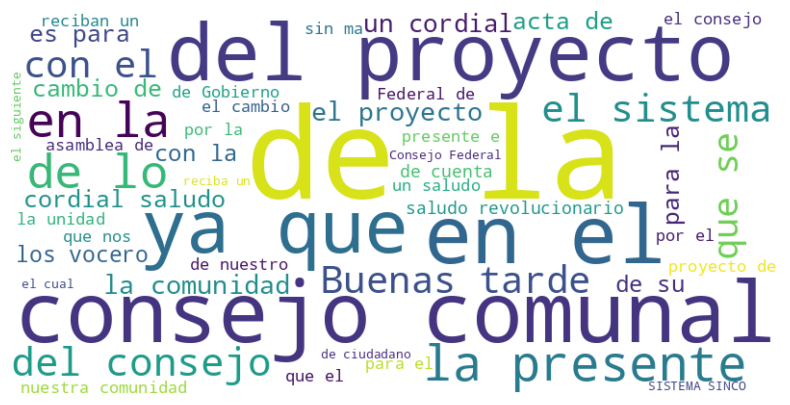

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combinar todos los mensajes en un solo texto
all_messages = ' '.join(df['messages'])

# Crear un objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='viridis').generate(all_messages)

# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Creando el dataset

In [ ]:
categorias = agrupado_por_frecuencia['category'].iloc[0:20]

In [ ]:
categorias

19                                     Cambio de vocería
86                     Proceso de valorción del proyecto
20                               Cancelación de proyecto
91                                  Rendición de cuentas
82                      Pasos para registrar un proyecto
17                          Cambio de correo electrónico
44                  Dificultad en el modulo de registrar
92                      Respuesta a comunicación emitida
54                                          Electricidad
53            Ejecución de Proyecto / REPORTE DE INSUMOS
90               Reclamos, sugerencias y agradecimientos
10                                                  Agua
85                   Problemas con el RIF o código Situr
9                                               Agrícola
84                       Problemas con cuentas bancarias
55                                 Estatus de desembolso
12                                Ayudas sociales varias
16     Calceclación de proyecto

In [ ]:
df[df['category'] == 'Cancelación de proyecto']['messages'].sample(n=1).values[0]

'<p class="MsoNormal">BUEN DÍA SALUDOS TENGAN USTEDES SEÑORES DEL SISTEMA SINCO \xa0GUÁRICO \xa0ME DIRIJO EN ESTA OPORTUNIDAD PARA PEDIR LA CANCELACIÓN\r\nDE UN PROYECTO DE POZO ALIBLE YA QUE POR TIEMPO DE LLUVIA NO ES CONVENIENTE\r\nPARA LA EJECUCIÓN DEL MISMO Y TOMANDO LA DECISIÓN EN ASAMBLEA DE CIUDADANO SE\r\nDECIDE LA CANCELACIÓN Y ASÍ PODER \xa0TOMAR\r\nOTRA PRIORIDAD QUE ES LA FALTA DE ELECTRICIDAD EN LA COMUNIDAD Y POR TAL MOTIVO\r\nPEDIMOS DE SU COLABOCION ESPERANDO UNA PRONTA Y SATISFACTORIA RESPUESTA NOS\r\nDESPEDIMOS VOCEROS DEL CONSEJO COMUNAL\xa0\r\nTSIDKENU.\xa0</p>'

In [ ]:
total_mensajes = df.shape[0]

In [ ]:
df = df.reset_index(drop = True)

In [ ]:
data = df[df['category'].isin(categorias)].reset_index(drop=True)

In [ ]:
mensajes_20 = data.shape[0]

In [ ]:
mensajes_20*100/total_mensajes

81.6166828814348

In [ ]:
data2 = data.iloc[:,1:3]
data2

,category,messages
0,Rendición de cuentas,"Reciban un saludo bolivariano, chavista y anti..."
1,Problemas con cuentas bancarias,"Saludos cordiales, les escribe la vocera Shirl..."
2,Rendición de cuentas,"SALUDOS, EL PRESENTE COMUNICADO EN CON LA FINA..."
3,Proceso de valorción del proyecto,"BUENAS NOCHES SEÑORES SINCO, RECIBAN UN CORDIA..."
4,Rendición de cuentas,buenas noches le solicito me oriente so...
...,...,...
19290,Respuesta a comunicación emitida,Actualmente la organización no posee ninguna p...
19291,Respuesta a comunicación emitida,Con este reporte llegamos a un 100% del total...
19292,Problemas con el RIF o código Situr,ANTE TODO RECIBA UN RESPETUOSO SALUDO DE PARTE...
19293,Cambio de vocería,"Buenas tarde, reciban un cordial saludo en ben..."


In [ ]:
agrupado_por_frecuencia = data2.groupby('category').size().reset_index(name='frecuencia').sort_values(by='frecuencia',ascending=False)

In [ ]:
agrupado_por_frecuencia

,category,frecuencia
6,Cambio de vocería,2687
15,Proceso de valorción del proyecto,2611
7,Cancelación de proyecto,2302
17,Rendición de cuentas,1797
12,Pasos para registrar un proyecto,1392
5,Cambio de correo electrónico,1126
8,Dificultad en el modulo de registrar,843
18,Respuesta a comunicación emitida,722
10,Electricidad,680
9,Ejecución de Proyecto / REPORTE DE INSUMOS,676


In [ ]:
#creamos vector de categorías (1 si pertenece a esa categoría y 0 si no)
for categoria in categorias:
  df[categoria] =df['category'].apply(lambda x: 1 if x == categoria else 0)

In [ ]:
data2.to_excel('datos_tesis_filtrado.xlsx',index=False)